In [2021]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2056]:
x = np.random.normal(1., 0.5, 100)
y = np.random.normal(0.5, 0.5, 100)
A = np.asarray([x,y])

x = np.random.normal(-1., 0.5, 100)
y = np.random.normal(0., 0.5, 100)
B = np.asarray([x,y])

x = np.empty(100)
x[:50] = np.random.normal(-1., 0.2, 50)
x[50:] = np.random.normal(1., 0.2, 50)
y = np.random.normal(0.3, 0.2, 100)
A = np.asarray([x,y])

x = np.random.normal(0., 0.3, 100)
y = np.random.normal(-0.1, 0.3, 100)
B = np.asarray([x,y])

In [2057]:
patterns = np.append(A, B, axis=1)
targets = np.append(np.ones(A.shape[1]), np.ones(B.shape[1]) * -1)

In [2058]:
permutation = np.random.permutation(len(targets))
targets = targets[permutation]
patterns = patterns[:,permutation]

In [2059]:
insize, ndata = patterns.shape
outsize = targets.shape

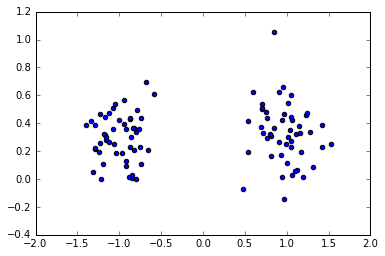

In [2060]:
ones = np.where(targets == 1)
plt.scatter(patterns[0,ones], patterns[1,ones])

In [2061]:
def delta(X, W, targets, eta=0.001):
    return -eta * (W.dot(X) - targets).dot(X.T)

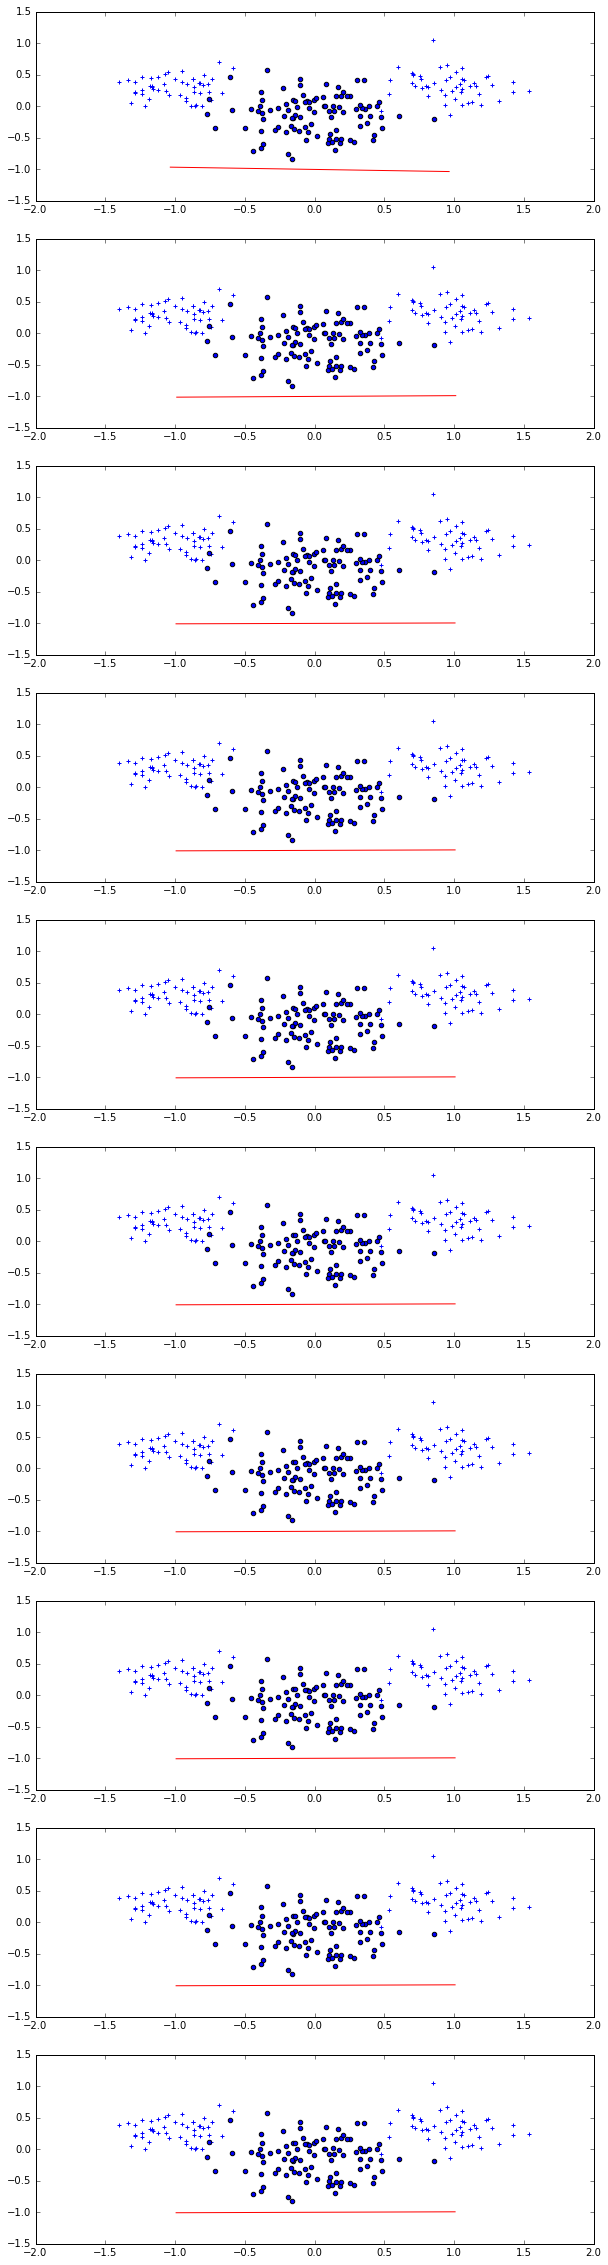

In [2062]:
W = np.zeros((1, len(patterns)))
W = get_random_weights(W.shape)

fig, axarr = plt.subplots(10,1, figsize=(10,40))
for i in range(10):
    W = delta(patterns, W, targets)
    p = W[0,:2]
    k = -W[0, insize - 1] / p.dot(p.T)
    l = np.sqrt(p.dot(p.T))
    pred = np.where(targets == 1)
    axarr[i].scatter(patterns[0,pred], patterns[1,pred], marker='+')
    pred = np.where(targets == -1)
    axarr[i].scatter(patterns[0,pred], patterns[1,pred], marker='o')
    x = np.array([p[0], p[0]]).dot(k) + [-p[1], p[1]]/l
    y = np.array([p[1], p[1]]).dot(k) + [p[0], -p[0]]/l
    axarr[i].plot(x, y, color='r')

In [2063]:
class MLP(object):
    
    def get_random_weights(shape):
        return np.random.uniform(low=-0.01, high=0.01, size=shape)   
    
    def __init__(self, X, T, layer_sizes):
        self.T = T
        self.layer_sizes = layer_sizes
        nr_data = X.shape[1]
        self.X = self.append_bias(X)
        nr_inputs = self.X.shape[0]
        nr_outputs = 1 if T.ndim == 1 else T.shape[0]

        W = []
        w = get_random_weights((layer_sizes[0], nr_inputs))
        W.append(w)
        for layer in range(len(layer_sizes) - 1):
            shape = (layer_sizes[layer + 1], layer_sizes[layer])
            w = get_random_weights(shape)
            W.append(w)
        w = get_random_weights((nr_outputs, layer_sizes[-1]))
        W.append(w)
        self.W = W
        
    def append_bias(self, X):
        return np.append(X, np.ones((1, X.shape[1])), axis=0)
        
    def phi(self, X):
        return 2. / (1 + np.exp(-X)) - 1
    
    def phi_gradient(self, X):
        return ((1 + self.phi(X)) * (1 - self.phi(X))) / 2.
        
    def forwards(self, X):
        nr_data = X.shape[1]
        layers = [X]
        for layer in range(len(self.W)):
            lin = self.W[layer].dot(layers[layer])
#             layers.append(np.append(self.phi(lin), np.ones((1, nr_data)), axis=0))
            layers.append(self.phi(lin))
        return layers
    
    def backwards(self, layers):
        deltas = [(layers[-1] - self.T) * self.phi_gradient(layers[-1])]
        
        for layer in xrange(len(self.W) - 1, 0, -1):
            delta = self.W[layer].T.dot(deltas[-1]) * self.phi_gradient(layers[layer])
            if layer == 0:
                delta = delta[:len(self.W) - 1, :]
            deltas.append(delta)
        deltas.reverse()
        return deltas
    
    def update_weights(self, dW, layers, deltas, eta, alpha):
        for layer in range(len(self.W)):
            dW[layer] = (dW[layer] * alpha) - (deltas[layer].dot(layers[layer].T)) * (1-alpha);
            self.W[layer] += dW[layer] * eta;
    
    def train(self, max_iterations=1000, eta=0.04, alpha=0.9):
        dW = [np.zeros(w.shape) for w in self.W]
        for i in range(max_iterations):
            layers = mlp.forwards(self.X)
            deltas = mlp.backwards(layers)
            mlp.update_weights(dW, layers, deltas, eta, alpha)
            e = np.sum(np.sum(np.abs(np.sign(layers[-1]) - self.T)/2))
        print 'e: %s' % str(e/len(self.T))

    def predict(self, X, apply_sign=False):
        X_bias = self.append_bias(X)
        out = mlp.forwards(X_bias)[-1]
        return np.sign(out) if apply_sign else out

In [2064]:
mlp = MLP(patterns, targets, layer_sizes=[3])
mlp.train()

nr outputs: 1
e: 0.02


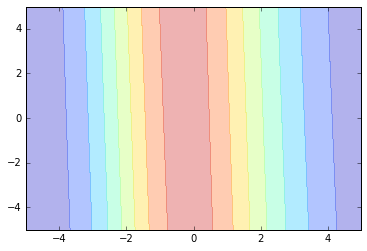

In [2136]:
x_min, x_max = patterns[0, :].min(), patterns[0, :].max()
y_min, y_max = patterns[1, :].min(), patterns[1, :].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

X_space = np.vstack([xx.ravel(), yy.ravel()])
Z = mlp.predict(X_space)

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3)

pred = np.where(targets == 1)
plt.scatter(patterns[0,pred], patterns[1,pred], marker='+')
pred = np.where(targets == -1)
plt.scatter(patterns[0,pred], patterns[1,pred], marker='o')

# Encoding problem

In [2084]:
encoding_patterns = np.eye(8).dot(2) - 1
encoding_targets = encoding_patterns
print encoding_patterns
mlp = MLP(encoding_patterns, encoding_targets, layer_sizes=[3])
mlp.train(eta=0.3, alpha=0.9)
predictions = mlp.predict(encoding_patterns)
print 'pred: %s' % predictions

[[ 1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1. -1. -1.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.]]
nr outputs: 8
e: 0.5
pred: [[-0.34328211 -0.9784554  -0.34328213 -0.99996936 -0.99918548 -0.99981281
  -0.34328211 -0.96403185]
 [-0.97813895  0.91056993 -0.97813895 -0.99999948 -1.         -0.87678235
  -0.97813895 -0.99999927]
 [-0.34330691 -0.97836891 -0.34330693 -0.99996912 -0.99918208 -0.9998114
  -0.34330691 -0.96397477]
 [-1.         -0.9999999  -1.          0.94538655 -0.79217448 -0.97157894
  -1.         -0.9999943 ]
 [-0.9996396  -0.99999968 -0.9996396  -0.96764553  0.66998567 -0.99999504
  -0.9996396  -0.74814747]
 [-0.99999999 -0.93876244 -0.99999999 -0.92424604 -0.99999987  0.91834976
  -0.99999999 -1.        ]
 [-0.34324948 -0.97857382 -0.3432495  -0.99996967 -0.9991898  -0.99981469
  -0.34324948

(101, 101)
(10201,)
nr outputs: 1
e: 0.396709867177
(2, 40401)
201
(1, 40401)


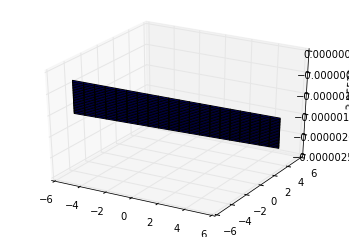

In [2144]:
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-5,5+0.1,0.1).reshape(1,-1).T
Y = X
Z = np.exp(-(X**2 * 0.1)).dot(np.exp(-(Y**2 * 0.1)).T) - 0.5

targets = Z.reshape(-1)
print Z.shape
print targets.shape
xx, yy = np.meshgrid(X, Y)

patterns = np.vstack([xx.ravel(), yy.ravel()])

mlp = MLP(patterns, targets, layer_sizes=[5])
mlp.train(eta=0.0005, alpha=0.5, max_iterations=1000)

x_test = np.arange(-5,5+0.05,0.05).reshape(1,-1)
xx, yy = np.meshgrid(x_test, x_test)
test = np.vstack([xx.ravel(), yy.ravel()])
out = mlp.predict(test)

gridsize = x_test.shape[1]
print test.shape
print gridsize
print out.shape
ZZ = out.reshape(gridsize, gridsize)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(x_test, x_test, ZZ)